In [1]:
# Add project src to path.
import set_path

import numpy as np
import pandas as pd
import pathlib
import laspy
from tqdm import tqdm

from upcp.labels import Labels
from upcp.utils import las_utils
from upcp.utils import ahn_utils

from upc_analysis import pole_extractor

QSocketNotifier: Can only be used with threads started with QThread


In [2]:
# AHN data folder.
ahn_data_folder = '../datasets/ahn/'
ahn_reader = ahn_utils.NPZReader(ahn_data_folder, caching=False)

# BGT data folder.
# bgt_building_file = '../datasets/bgt/bgt_buildings_demo.csv'
# bld_reader = bgt_utils.BGTPolyReader(bgt_building_file, building_offset=0)
bld_reader = None

In [3]:
dataset_folder = '../datasets/pointcloud/'
prefix = 'processed_'
files = list(pathlib.Path(dataset_folder).glob(f'{prefix}*.laz'))

---

In [4]:
min_component_size = 100
target_label = Labels.STREET_LIGHT
ground_labels = [Labels.GROUND, Labels.ROAD]

HEADERS = ['rd_x', 'rd_y', 'z', 'tx', 'ty', 'tz', 'height', 'angle', 'prob', 'n_points', 'in_bld', 'debug', 'tilecode']
locations = []

for file in tqdm(files):
    tilecode = las_utils.get_tilecode_from_filename(file.as_posix())
    pc = laspy.read(file)
    labels = pc.label
    if 'probability' in pc.point_format.extra_dimension_names:
        probabilities = pc.probability
    else:
        probabilities = np.zeros_like(labels)

    if np.count_nonzero(labels == target_label) > 0:
        points = np.vstack((pc.x, pc.y, pc.z)).T
        if bld_reader is not None:
            bld_polygons = bld_reader.filter_tile(tilecode, merge=True)
        else:
            bld_polygons = None
        tile_locations = pole_extractor.get_pole_locations(
                            points, labels, probabilities, target_label, ground_labels,
                            ahn_reader, tilecode, bld_polygons,
                            min_component_size=min_component_size)
        locations.extend([(*x, tilecode) for x in tile_locations])

poles_df = pd.DataFrame(locations, columns=HEADERS)

100%|█████████████████████████████████████████████| 2/2 [00:09<00:00,  4.91s/it]


In [5]:
poles_df

,rd_x,rd_y,z,tx,ty,tz,height,angle,prob,n_points,in_bld,debug,tilecode
0,119325.25,485103.27,0.38,119325.19,485103.37,7.60,7.22,0.91,0.0,5730,0,0_0,2386_9702
1,119313.05,485104.17,0.51,119312.87,485104.22,7.82,7.31,1.43,0.0,4482,0,0_0,2386_9702
2,119341.53,485113.85,0.41,119341.62,485113.82,7.60,7.19,0.72,0.0,4476,0,0_0,2386_9702
3,119338.62,485122.56,0.56,119338.81,485122.55,7.75,7.19,1.53,0.0,5974,0,0_0,2386_9702
4,119318.87,485146.92,0.20,119318.83,485146.94,5.30,5.11,0.55,0.0,3717,0,0_0,2386_9702
5,119896.66,485255.75,0.35,119896.44,485255.78,6.91,6.56,1.96,0.0,11494,0,0_0,2397_9705
6,119891.84,485267.01,0.46,119891.73,485266.99,7.01,6.55,0.98,0.0,17340,0,0_0,2397_9705
7,119876.82,485287.90,0.65,119876.81,485287.87,7.23,6.58,0.32,0.0,17632,0,0_0,2397_9705
8,119894.37,485287.05,0.72,119894.26,485287.37,7.05,6.34,3.05,0.0,4766,0,0_0,2397_9705
9,119866.94,485289.82,0.43,119867.14,485290.16,6.91,6.49,3.52,0.0,26330,0,0_0,2397_9705


---

In [11]:
idx = np.random.randint(0, len(poles_df))
row_id = poles_df.index[idx]

obj_df = poles_df.loc[[row_id]]
obj = poles_df.loc[row_id]
tilecode = obj.tilecode
obj_loc = (obj.rd_x, obj.rd_y, obj.z)
obj_top = (obj.tx, obj.ty, obj.tz)
obj_angle = obj.angle

obj_df

,rd_x,rd_y,z,tx,ty,tz,height,angle,prob,n_points,in_bld,debug,tilecode
4,119318.87,485146.92,0.2,119318.83,485146.94,5.3,5.11,0.55,0.0,3717,0,0_0,2386_9702


In [12]:
cloud = laspy.read(f'{dataset_folder}{prefix}{tilecode}.laz')
points = np.vstack((cloud.x, cloud.y, cloud.z)).T
colors = np.vstack((cloud.red, cloud.green, cloud.blue)).T / (2**16 - 1)

In [13]:
from upcp.region_growing import LabelConnectedComp
from upcp.utils import math_utils
from upcp.utils import clip_utils

target_idx = np.where(cloud.label == target_label)[0]

noise_components = (LabelConnectedComp(
                        grid_size=0.2,
                        min_component_size=10)
                    .get_components(points[target_idx]))
noise_filter = noise_components != -1
point_components = (LabelConnectedComp(
                        grid_size=0.2,
                        min_component_size=100)
                    .get_components(points[target_idx[noise_filter], 0:2]))

cc_labels, counts = np.unique(point_components, return_counts=True)
cc_labels_valid = [l for l in cc_labels if l != -1]

off_eps = 0.05
obj_idx = -1
for cc in cc_labels_valid:
    cc_mask = point_components == cc
    min_x, max_y, max_x, min_y = math_utils.compute_bounding_box(points[target_idx][noise_filter][cc_mask])
    off_h = np.min(points[target_idx][noise_filter][cc_mask, 2]) - obj_loc[2]
    offset = np.sqrt((off_h / np.sin(np.deg2rad(90 - obj_angle)))**2 - off_h**2) + off_eps
    min_x -= offset
    min_y -= offset
    max_x += offset
    max_y += offset
    if min_x <= obj_loc[0] <= max_x and min_y <= obj_loc[1] <= max_y:
        obj_idx = int(cc)
        break
if obj_idx == -1:
    print("No match found!")
    pad = 1
    box = (obj_loc[0]-pad, obj_loc[1]-pad, obj_loc[0]+pad, obj_loc[1]+pad)
else:
    pad = 0.5
    box = (min_x-pad, min_y-pad, max_x+pad, max_y+pad)
    obj_mask = target_idx[noise_filter][cc_mask]

bg_mask = clip_utils.box_clip(points, box, bottom=obj_loc[2]-pad, top=obj_top[2]+2)

No match found!


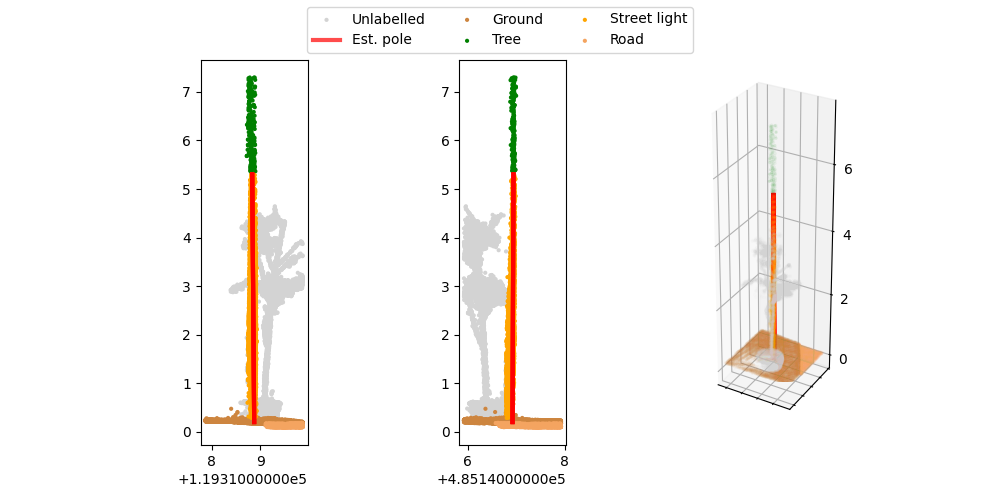

In [14]:
%matplotlib widget
import matplotlib.pyplot as plt
from upcp.utils import plot_utils

xs = points[bg_mask, 0]
ys = points[bg_mask, 1]
zs = points[bg_mask, 2]
# cs = colors[bg_mask, :]
labels = cloud.label[bg_mask]

estimate = np.vstack((obj_loc, obj_top))

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133, projection='3d')

label_set = np.unique(labels)

for label in label_set:
    if label == Labels.NOISE:
        continue
    label_mask = labels == label
    label_str = Labels.get_str(label)
        
    ax1.scatter(xs[label_mask], zs[label_mask], c=plot_utils.cloud_colors[label_str], marker='.', edgecolors='none', alpha=1, label=label_str)
    ax1.plot(estimate[:, 0], estimate[:, 2], c='red', linewidth=3, alpha=0.7, label='Est. pole')

    ax2.scatter(ys[label_mask], zs[label_mask], c=plot_utils.cloud_colors[label_str], marker='.', edgecolors='none', alpha=1)
    ax2.plot(estimate[:, 1], estimate[:, 2], c='red', linewidth=3, alpha=0.7)

    ax3.scatter(xs[label_mask], ys[label_mask], zs[label_mask], c=plot_utils.cloud_colors[label_str], marker='.', edgecolors='none', alpha=0.05)
    ax3.plot(estimate[:, 0], estimate[:, 1], estimate[:, 2], c='red', linewidth=3, alpha=1)

ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax3.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
ax3.xaxis.set_ticklabels([])
ax3.yaxis.set_ticklabels([])
ax3.dist = 8

handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(),
           loc='upper center', bbox_to_anchor=(0.5, 1), ncol=int(len(by_label) / 2 + 0.5))

fig.subplots_adjust(wspace=0, hspace=0)

plt.show()